# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
df.columns

Index(['temperature', 'gender', 'heart_rate'], dtype='object')

In [3]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


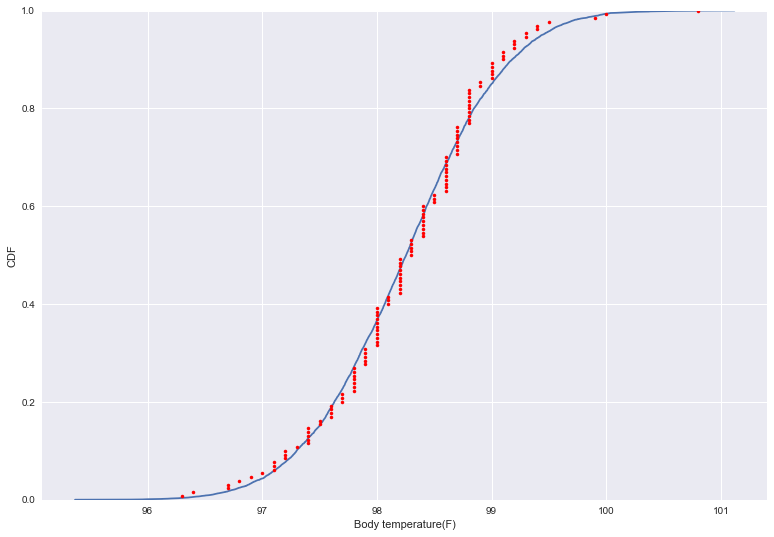

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n=len(data)
    # x-data for the ECDF: x
    x=np.sort(data)
    #step=int((max(data)-min(data))/0.1)+1
    #x=np.arange(min(data),max(data),0.1)
    # y-data for the ECDF: y
    y = np.arange(1, n+1)/n
    return x, y
    
sns.set()
mean=np.mean(df['temperature'])
std=np.std(df['temperature'])
samples = np.random.normal(mean, std, size=10000)
x, y = ecdf(df['temperature'])
x_theor, y_theor = ecdf(samples)

fig = plt.figure(figsize=(13, 9))
_ = plt.ylim(0, 1)
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none',color='red')
_ = plt.xlabel('Body temperature(F)')
_ = plt.ylabel('CDF')
plt.show()


## 1. Is the distribution of body temperatures normal? 
 <ul>
    <li> Figure shows that the actual CDF is very close to theory normal CDF. Therefore it may follow the normal distribution.
    </ul>

In [6]:
np.mean(df['temperature'])

98.24923076923078

In [7]:
import scipy.stats as stats
stats.normaltest(df['temperature'])

NormaltestResult(statistic=2.703801433319203, pvalue=0.2587479863488254)

<ul> p-value of normal test using stats package equals 0.259 which is greater than 0.05. Therefore it is safe to accept null hypotheis, meaning it follows normal distribution  </ul>


##  2. Is the sample size large? Are the observations independent?
<ul>
    These two conditions are criteiors to central limit theorem and needs to be satisfied to use statistic test
</ul>
Since there are 130 samples for this problem, according to http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Probability/BS704_Probability12.html. When n>=30 it is ok to apply central limit theorem.

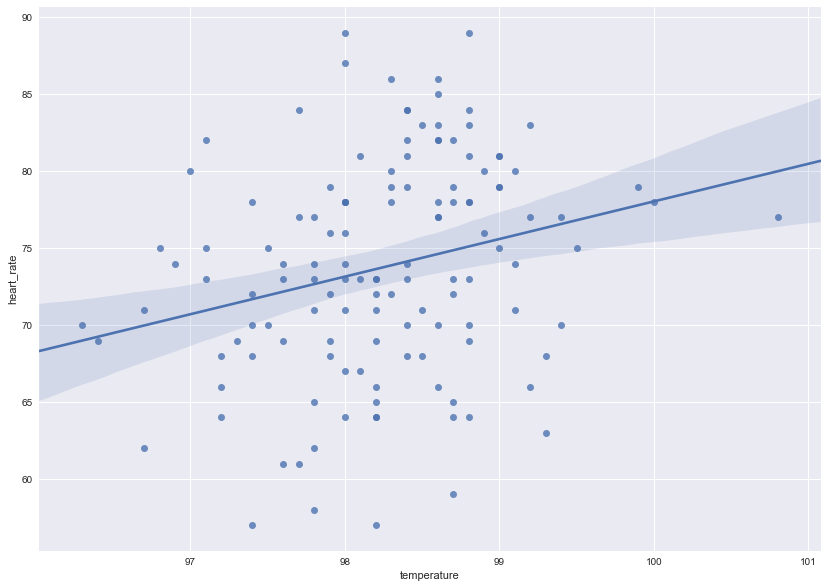

In [8]:
## Normalizing data for comparison
fig = plt.figure(figsize=(14, 10))
sns.regplot(df['temperature'], df['heart_rate'])

Figure shows the independence beween temperature and heart rate, meaning higher temperature does not lead to higher heart rate. 

## 3. Is the true population mean really 98.6 degrees F?
using bootstrap resample technique, hypothesis test is conducted with the null hypothesis:

    H0: population mean = 98.6
    HL: population mean < 98.6
with resampling for 10000 times, it is calculated that p-value to be 0.00 and it is feasible to reject null hypothesis, meaning the mean temperature is less than 98.6 F

-0.35076923076921673


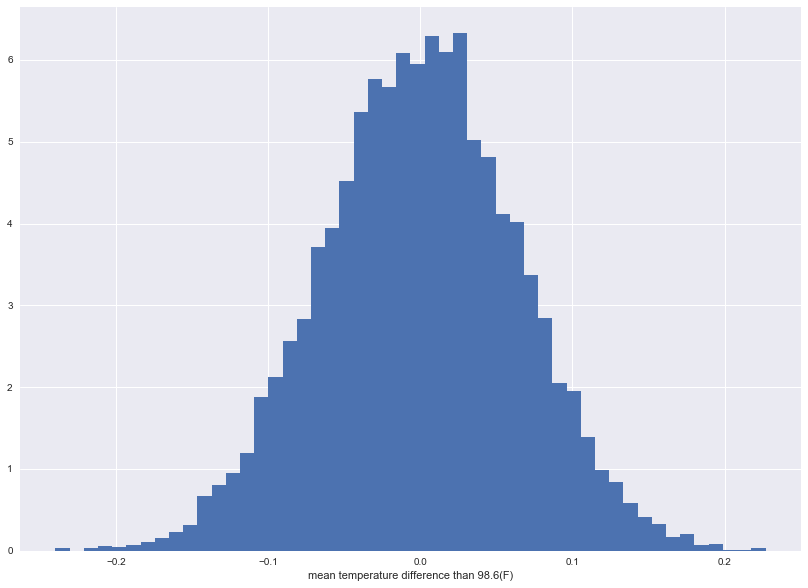

p value=0.0000000


In [9]:
def diff_target(data,target=98.6):
    return np.mean(data)-target

def bootstrap_replicate_1d(data, diff_target):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return diff_target(bs_sample)


diff_obs=diff_target(df['temperature'])
bs_replicates = np.empty(10000)
df1=df['temperature']-np.mean(df['temperature'])+98.6
print(diff_obs)
for i in range(10000):
    bs_replicates[i] = bootstrap_replicate_1d(df1, diff_target)
    
fig = plt.figure(figsize=(14, 10))    
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('mean temperature difference than 98.6(F)')

plt.show()

p=np.sum(bs_replicates<=diff_obs)/len(bs_replicates)

print('p value=%8.7f' % p)

From Bootstrap sampleing testing, the percentage of temperature differences that are less than observed difference < 0.0000, therefore most of the differences are greater than the observed difference and we reject null hypothesis, meaning the temperature is less than 98.6 

In [10]:
stats.ttest_1samp(df['temperature'], popmean=98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

    Which one is the correct one to use?
    What do you notice? What does this tell you about the difference in application of the tt and zz statistic? 

In [11]:
def bootstrap_replicate(data,size, diff_target):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, size)
    return diff_target(bs_sample)

bs_replicates = np.empty(10000)
df1=df['temperature']-np.mean(df['temperature'])+98.6

for i in range(10000):
    bs_replicates[i] = bootstrap_replicate(df1,10, diff_target)
    

p=np.sum(bs_replicates<=diff_obs)/len(bs_replicates)

print('p value=%8.7f' % p)

stats.ttest_1samp(bs_replicates, popmean=98.6)

p value=0.0634000


Ttest_1sampResult(statistic=-42587.178423227844, pvalue=0.0)

By drawing 10 samples from the data and do bootstrap sampling, t test is used to conduct the hypothesis testing showing p value of 0.00 which rejects null hypothesis. so these 10 samples indicate mean temperature is not 98.6F

## 5. At what temperature should we consider someone's temperature to be "abnormal"?

    As in the previous example, try calculating everything using the boostrap 

In [12]:
conf_int = np.percentile(df['temperature'], [2.5, 97.5])

In [13]:
conf_int

array([96.7225, 99.4775])

So the above calculation indicates the normal range is (96.72, 99.48). Any temperature beyond this range is considered as abnormal 

Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why? 

In [14]:
stats.ttest_1samp(df['temperature'], popmean=98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

Since we are searching the true value of 1 sample using the t test on sample mean against the true mean, it is a one sample test. Because it is involed only one sample, t test is used. Z test is to used for 2 samples mean comparion. 

t test result is showing p value=2.4 e-7 and this agrees well with the bootsrap tesing result.

## 6. Is there a significant difference between males and females in normal temperature?

    What testing approach did you use and why?
    Write a story with your conclusion in the context of the original problem. 

In [15]:
temp_female=df[df['gender']=='F']['temperature']

In [16]:
temp_male=df[df['gender']=='M']['temperature']

In [17]:
stats.ttest_ind(temp_male,temp_female)

Ttest_indResult(statistic=-2.2854345381656103, pvalue=0.02393188312239561)

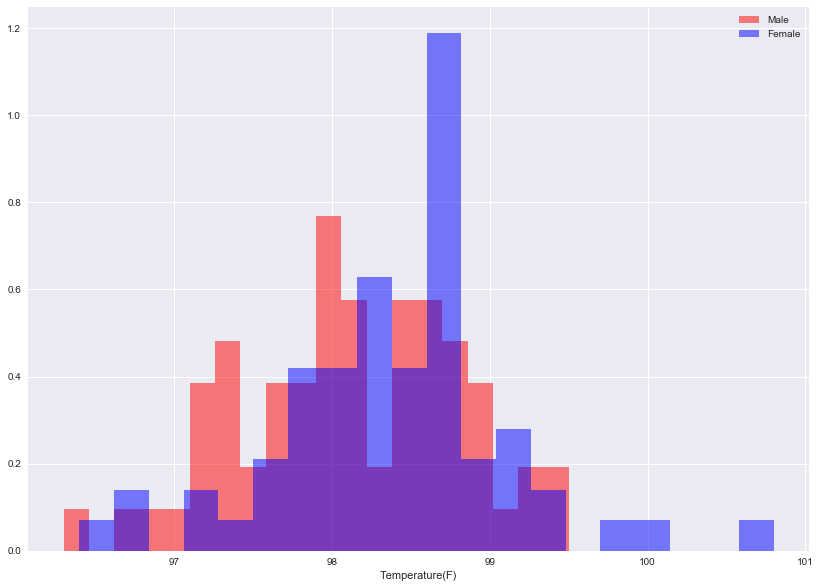

In [18]:
fig = plt.figure(figsize=(14, 10))
_ = plt.hist(temp_male, bins=20, normed=True,color='red',label='Male',alpha=0.5)
_ = plt.hist(temp_female, bins=20, normed=True,color='Blue',label='Female',alpha=0.5)
_ = plt.xlabel('Temperature(F)')
_ = plt.legend(loc='upper right')
plt.show()

p value for t test for difference between female and male temperatures and p value is calculated to be 0.024 which is less than 0.05 and we may reject null hypothesis. Thus we accept that the female temperature is higher than male. 

## Conclusion
98.6 degrees F is a very fair estimate for a study published in the 1800's. In this study true normal temperature is found to be less than 98.6 F with both bootstrap sampling and t test as well. The dataset of interest is normally distributed. In the meanwhile, the normal temperature range is calculated therefore the abnoraml readings are defined. Finally, it is discovered that females have higher temperatures than males do. 